# Best ML Model for Sentiment Analysis (Rinconada Dataset)

This notebook follows the research process to train and select the best ML algorithm (SVM, Naive Bayes, Random Forest) for sentiment classification.

In [19]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

## Load and Preprocess Data

In [20]:
# Load dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')
# Load stopwords
with open('RBL Nabua Stop Words.csv', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f if line.strip()])
# Preprocess function
def preprocess(text):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)
df['processed'] = df['Sentiment'].astype(str).apply(preprocess)
df[['Sentiment', 'processed', 'Label']].head()

,Sentiment,processed,Label
0,magmaan igin ninyo,magmaan igin ninyo,positive
1,mahiwason ang rinconada,mahiwason ang rinconada,positive
2,simpleng uran baha nanaman lriga,simpleng uran baha nanaman lriga,negative
3,uda karapatan reklamo lalo kadaklan taga rinco...,uda karapatan reklamo lalo kadaklan taga rinco...,negative
4,maray iba diri apektado,maray iba diri apektado,negative


## Feature Extraction (TF-IDF)

In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed'])
y = df['Label']

## Train/Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## K-Fold Cross Validation & Model Training

In [23]:
kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state=1)
models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=1)
    ,'NaiveBayes': MultinomialNB()
    ,'RandomForest': RandomForestClassifier(n_estimators=100, random_state=1)
}
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results[name] = cv_scores
    print(f"{name} CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

SVM CV Accuracy: 0.6416 (+/- 0.0119)
NaiveBayes CV Accuracy: 0.6121 (+/- 0.0091)
RandomForest CV Accuracy: 0.6202 (+/- 0.0080)


## Select Best Model & Evaluate on Test Set

In [24]:
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f'Best Model: {best_model_name}')
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Model: SVM
Test Accuracy: 0.644593088071349
Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.45      0.52       835
     neutral       0.66      0.84      0.74      2390
    positive       0.62      0.40      0.48      1260

    accuracy                           0.64      4485
   macro avg       0.63      0.56      0.58      4485
weighted avg       0.64      0.64      0.63      4485



## Save Best Model and Vectorizer

In [25]:
import os
model_path = f'best_model_{best_model_name}.obj'
vectorizer_path = 'tfidf_vectorizer.obj'
joblib.dump(best_model, model_path)
joblib.dump(vectorizer, vectorizer_path)
print(f'Saved best model as {model_path} and vectorizer as {vectorizer_path}')

Saved best model as best_model_SVM.obj and vectorizer as tfidf_vectorizer.obj


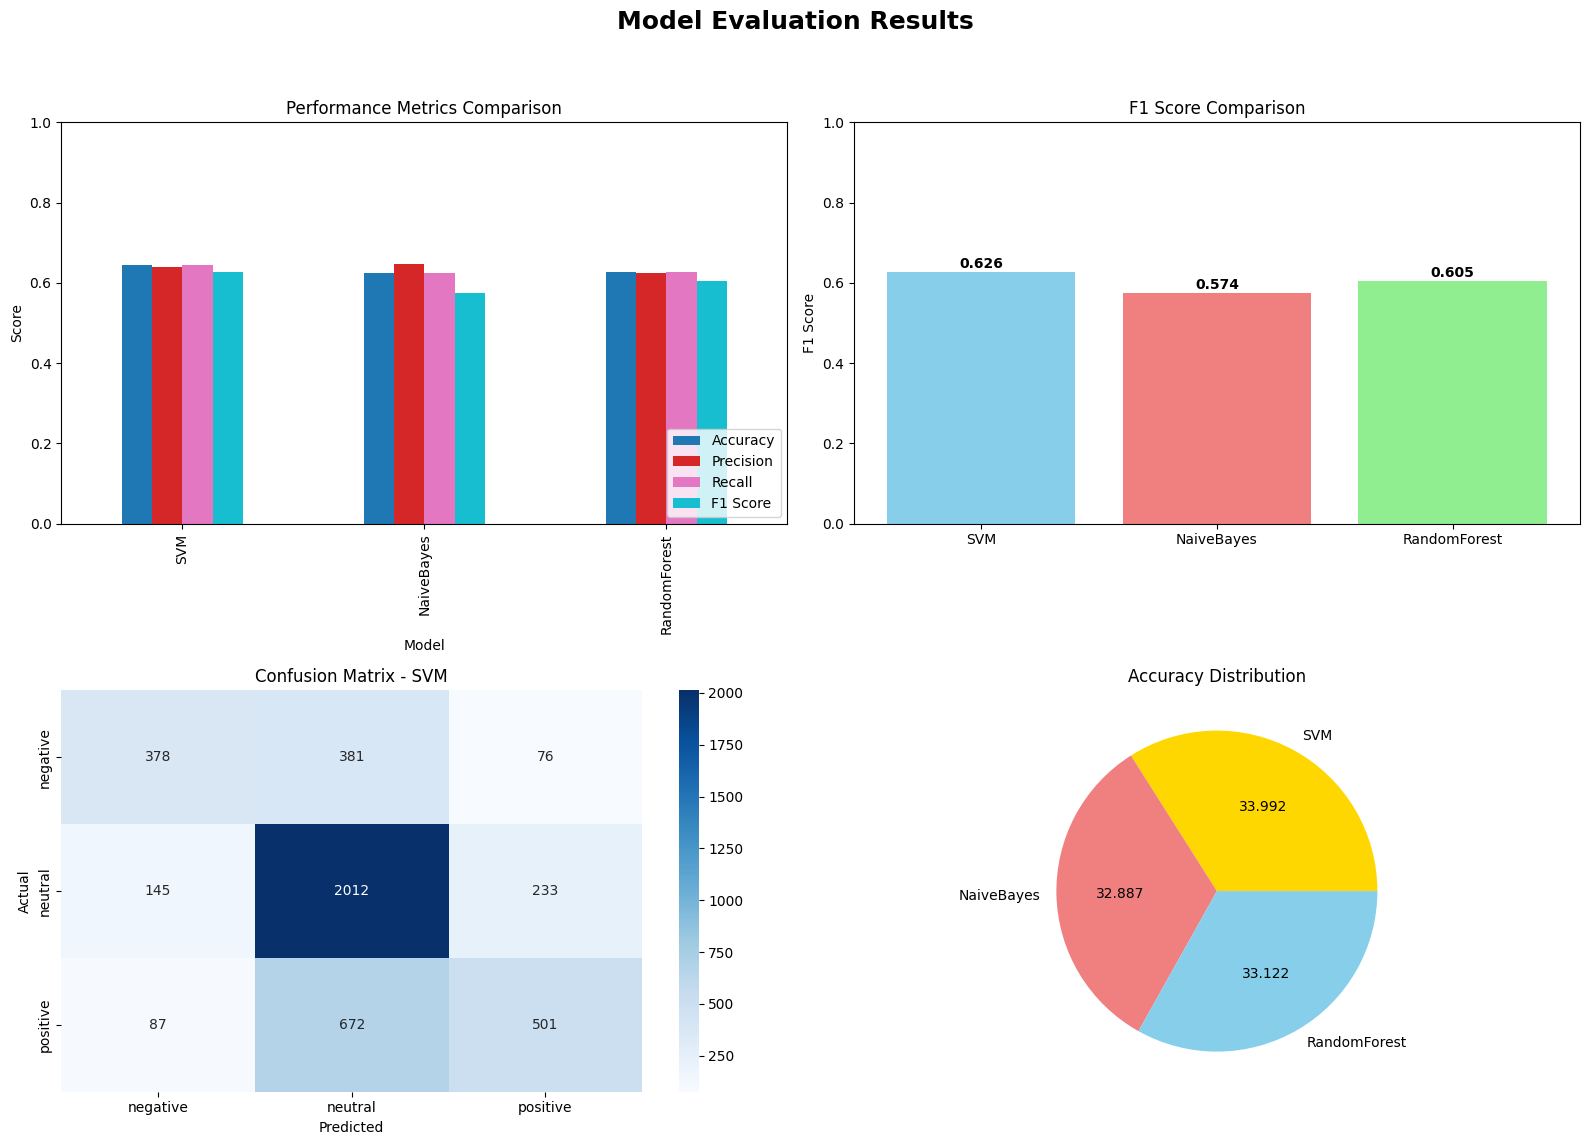

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Compute metrics for the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Compute metrics for all models
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_all = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred_all))
    metrics['Precision'].append(precision_score(y_test, y_pred_all, average='weighted', zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred_all, average='weighted', zero_division=0))
    metrics['F1 Score'].append(f1_score(y_test, y_pred_all, average='weighted', zero_division=0))
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

# Confusion Matrix for best model
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Classification report as DataFrame
cr = classification_report(y_test, y_pred, output_dict=True)
cr_dict = {k: [v['precision'], v['recall'], v['f1-score']] for k, v in cr.items() if k in best_model.classes_}
cr_df = pd.DataFrame(cr_dict, index=['Precision', 'Recall', 'F1-Score']).T

# Plot all in one figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Evaluation Results', fontsize=18, fontweight='bold')

# 1. Metrics Bar Plot
metrics_df.plot(kind='bar', ax=axes[0,0], colormap='tab10')
axes[0,0].set_title('Performance Metrics Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].set_ylim(0,1)
axes[0,0].legend(loc='lower right')

# 2. F1 Score Comparison
axes[0,1].bar(metrics_df.index, metrics_df['F1 Score'], color=['skyblue','lightcoral','lightgreen'])
for i, v in enumerate(metrics_df['F1 Score']):
    axes[0,1].text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
axes[0,1].set_title('F1 Score Comparison')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_ylim(0,1)

# 3. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_, ax=axes[1,0])
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')

# 4. Accuracy Pie Chart
axes[1,1].pie(metrics_df['Accuracy'], labels=metrics_df.index, autopct='%1.3f', colors=['gold','lightcoral','skyblue'])
axes[1,1].set_title('Accuracy Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics for the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# # Compute metrics for all models
# metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred_all = model.predict(X_test)
#     metrics['Model'].append(name)
#     metrics['Accuracy'].append(accuracy_score(y_test, y_pred_all))
#     metrics['Precision'].append(precision_score(y_test, y_pred_all, average='weighted', zero_division=0))
#     metrics['Recall'].append(recall_score(y_test, y_pred_all, average='weighted', zero_division=0))
#     metrics['F1 Score'].append(f1_score(y_test, y_pred_all, average='weighted', zero_division=0))

# metrics_df = pd.DataFrame(metrics)
# metrics_df.set_index('Model', inplace=True)

# # Grouped bar plot for all metrics
# metrics_df.plot(kind='bar', figsize=(10,6))
# plt.title('Performance Metrics Comparison')
# plt.ylabel('Score')
# plt.ylim(0,1)
# plt.legend(loc='lower right')
# plt.show()

Accuracy: 0.645
Precision: 0.639
Recall: 0.645
F1 Score: 0.626
